# BTVN số 2 (DL 06/03/2026)
Thử trên tập data MNIST và Cat and dog
Nhưng:
- Phải làm theo cấu trúc của file lab
- Dừng touch

## PHẦN A: PHÂN LOẠI CHỮ SỐ MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 5

Using device: cpu


In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = torchvision.datasets.MNIST(
    root='./data', train=True, transform=mnist_transform, download=True
)
mnist_test = torchvision.datasets.MNIST(
    root='./data', train=False, transform=mnist_transform, download=True
)

mnist_train_loader = DataLoader(
    dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=True
)
mnist_test_loader = DataLoader(
    dataset=mnist_test, batch_size=BATCH_SIZE, shuffle=False
)

print(f"MNIST - Số lượng ảnh train: {len(mnist_train)}")
print(f"MNIST - Số lượng ảnh test: {len(mnist_test)}")

MNIST - Số lượng ảnh train: 60000
MNIST - Số lượng ảnh test: 10000


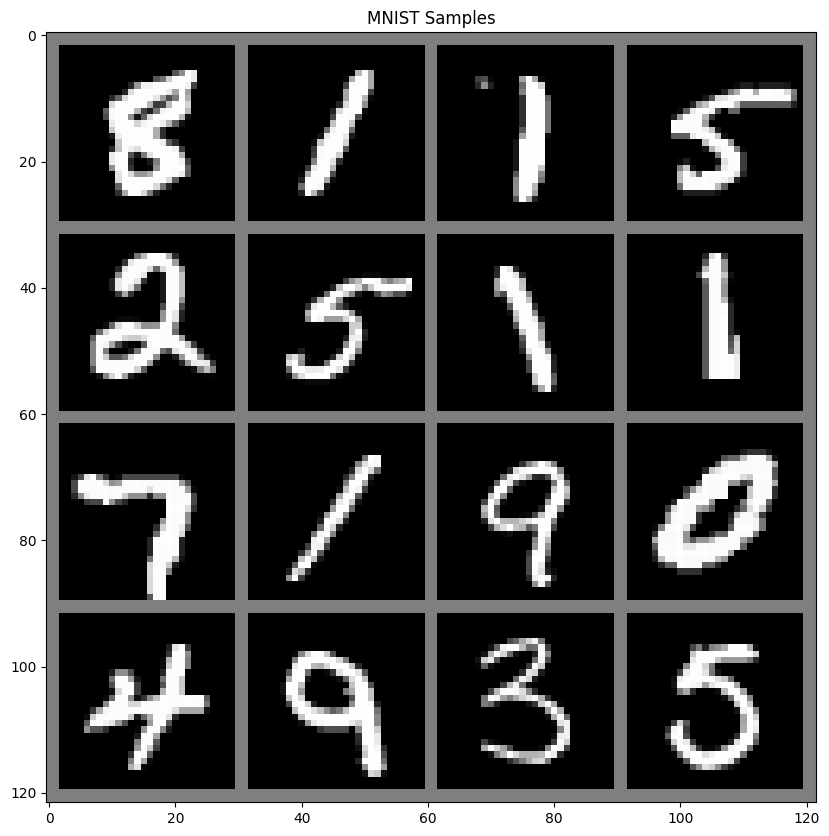

MNIST Labels: [8, 1, 1, 5, 2, 5, 1, 1, 7, 1, 9, 0, 4, 9, 3, 5]


In [ ]:
def imshow_mnist(img, title=None):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    if title:
        plt.title(title)
    plt.show()
dataiter = iter(mnist_train_loader)
images, labels = next(dataiter)


plt.figure(figsize=(10, 10))
imshow_mnist(torchvision.utils.make_grid(images[:16], nrow=4), 
       title="MNIST Samples")
print('MNIST Labels:', labels[:16].tolist())

In [4]:
class MNIST_ANN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MNIST_ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

mnist_model = MNIST_ANN().to(device)
print("MNIST Model:")
print(mnist_model)

MNIST Model:
MNIST_ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_model.parameters(), lr=LEARNING_RATE)
mnist_loss_history = []

print("Bắt đầu huấn luyện MNIST...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, (images, labels) in enumerate(mnist_train_loader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = mnist_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(mnist_train_loader)
    mnist_loss_history.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}')

print("Huấn luyện MNIST hoàn tất!")


Bắt đầu huấn luyện MNIST...
Epoch [1/5], Loss: 0.3808
Epoch [2/5], Loss: 0.1987
Epoch [3/5], Loss: 0.1401
Epoch [4/5], Loss: 0.1116
Epoch [5/5], Loss: 0.0950
Huấn luyện MNIST hoàn tất!


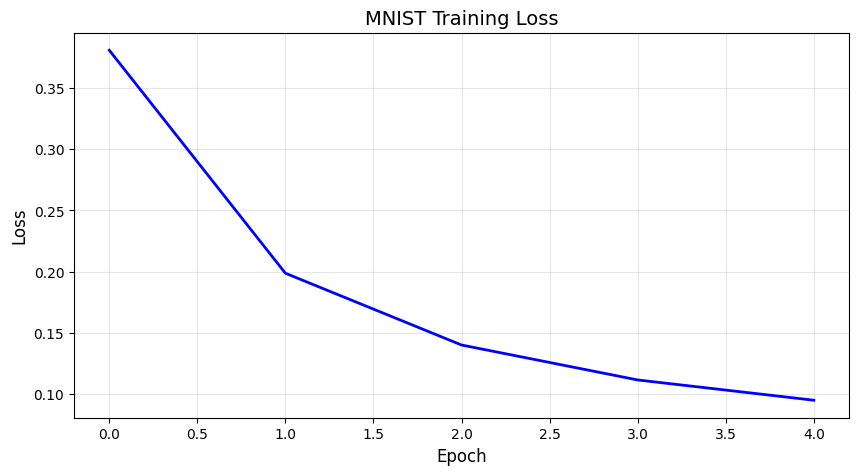

MNIST - Độ chính xác trên 10,000 ảnh test: 96.84 %


In [6]:
plt.figure(figsize=(10, 5))
plt.plot(mnist_loss_history, 'b-', linewidth=2)
plt.title('MNIST Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in mnist_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mnist_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

mnist_accuracy = 100 * correct / total
print(f'MNIST - Độ chính xác trên 10,000 ảnh test: {mnist_accuracy:.2f} %')

MNIST - Thực tế:  [7, 2, 1, 0, 4]
MNIST - Dự đoán:  [7, 2, 1, 0, 4]


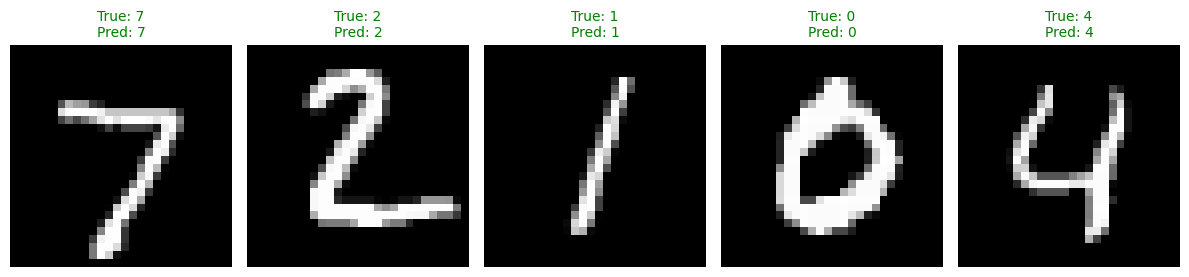

In [ ]:
dataiter = iter(mnist_test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

output = mnist_model(images[:5])
_, predicted = torch.max(output, 1)

print('MNIST - Thực tế: ', labels[:5].cpu().tolist())
print('MNIST - Dự đoán: ', predicted.cpu().tolist())

plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = images[i].cpu().squeeze()
    img = img / 2 + 0.5  
    plt.imshow(img, cmap='gray')
    color = 'green' if labels[i] == predicted[i] else 'red'
    plt.title(f'True: {labels[i].item()}\nPred: {predicted[i].item()}', 
              color=color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

## PHẦN B: PHÂN LOẠI CHÓ VÀ MÈO (CAT & DOG)

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
       
        cat_dir = os.path.join(root_dir, 'Cat')
        dog_dir = os.path.join(root_dir, 'Dog')
        
       
        if os.path.exists(cat_dir):
            for img_name in os.listdir(cat_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(cat_dir, img_name))
                    self.labels.append(0)
        

        if os.path.exists(dog_dir):
            for img_name in os.listdir(dog_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(dog_dir, img_name))
                    self.labels.append(1)  
        
        print(f"Tìm thấy {len(self.images)} ảnh: {self.labels.count(0)} mèo, {self.labels.count(1)} chó")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            print(f"Lỗi đọc ảnh {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.images))

In [ ]:
catdog_transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

catdog_transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

data_dir = './data'
catdog_full_dataset = CatDogDataset(
    root_dir=data_dir,
    transform=catdog_transform
)

from torch.utils.data import random_split
train_size = int(0.8 * len(catdog_full_dataset))
test_size = len(catdog_full_dataset) - train_size
catdog_train, catdog_test = random_split(
    catdog_full_dataset, [train_size, test_size]
)

catdog_test.dataset.transform = catdog_transform_val

catdog_train_loader = DataLoader(
    dataset=catdog_train, batch_size=BATCH_SIZE, shuffle=True
)
catdog_test_loader = DataLoader(
    dataset=catdog_test, batch_size=BATCH_SIZE, shuffle=False
)

print(f"Cat & Dog - Số lượng ảnh train: {len(catdog_train)}")
print(f"Cat & Dog - Số lượng ảnh test: {len(catdog_test)}")

Tìm thấy 25000 ảnh: 12500 mèo, 12500 chó
Cat & Dog - Số lượng ảnh train: 20000
Cat & Dog - Số lượng ảnh test: 5000


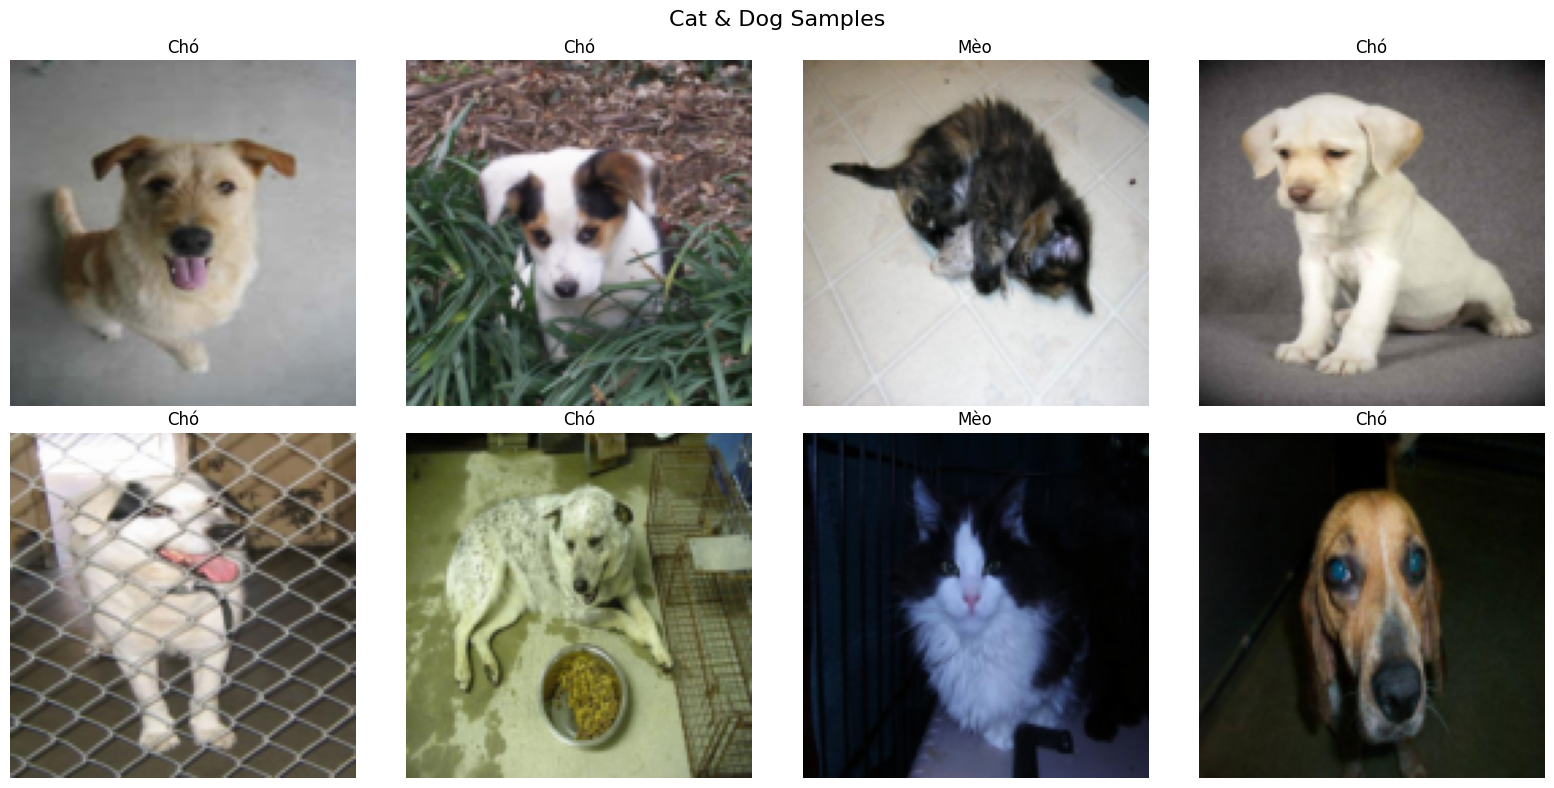

In [ ]:
def imshow_catdog(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
dataiter = iter(catdog_train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = images[i].cpu()
    label = "Mèo" if labels[i] == 0 else "Chó"
    imshow_catdog(img, title=f'{label}')
plt.suptitle('Cat & Dog Samples', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
class CatDogCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CatDogCNN, self).__init__()
       
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
          
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
           
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
           
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
      
        self._to_linear = None
        self._get_conv_output()
        
    
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def _get_conv_output(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 128, 128)
            dummy = self.conv_layers(dummy)
            self._to_linear = dummy.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

catdog_model = CatDogCNN().to(device)
print("Cat & Dog CNN Model:")
print(catdog_model)
print(f"Kích thước feature vector: {catdog_model._to_linear}")

Cat & Dog CNN Model:
CatDogCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
criterion_catdog = nn.CrossEntropyLoss()
optimizer_catdog = optim.Adam(catdog_model.parameters(), lr=LEARNING_RATE)
catdog_loss_history = []
catdog_acc_history = []

print("Bắt đầu huấn luyện Cat & Dog...")
for epoch in range(EPOCHS):
    # Training
    catdog_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (images, labels) in enumerate(catdog_train_loader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = catdog_model(images)
        loss = criterion_catdog(outputs, labels)
        
        optimizer_catdog.zero_grad()
        loss.backward()
        optimizer_catdog.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(catdog_train_loader)
    epoch_acc = 100 * correct_train / total_train
    catdog_loss_history.append(epoch_loss)
    catdog_acc_history.append(epoch_acc)
    
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

print("Huấn luyện Cat & Dog hoàn tất!")


Bắt đầu huấn luyện Cat & Dog...


/opt/homebrew/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Lỗi đọc ảnh ./data/Cat/666.jpg: cannot identify image file './data/Cat/666.jpg'
Epoch [1/5], Loss: 0.9179, Train Acc: 62.70%
Lỗi đọc ảnh ./data/Cat/666.jpg: cannot identify image file './data/Cat/666.jpg'
Epoch [2/5], Loss: 0.5388, Train Acc: 72.95%
Lỗi đọc ảnh ./data/Cat/666.jpg: cannot identify image file './data/Cat/666.jpg'
Epoch [3/5], Loss: 0.4553, Train Acc: 78.83%
Lỗi đọc ảnh ./data/Cat/666.jpg: cannot identify image file './data/Cat/666.jpg'
Epoch [4/5], Loss: 0.4051, Train Acc: 82.28%
Lỗi đọc ảnh ./data/Cat/666.jpg: cannot identify image file './data/Cat/666.jpg'
Epoch [5/5], Loss: 0.3579, Train Acc: 84.73%
Huấn luyện Cat & Dog hoàn tất!


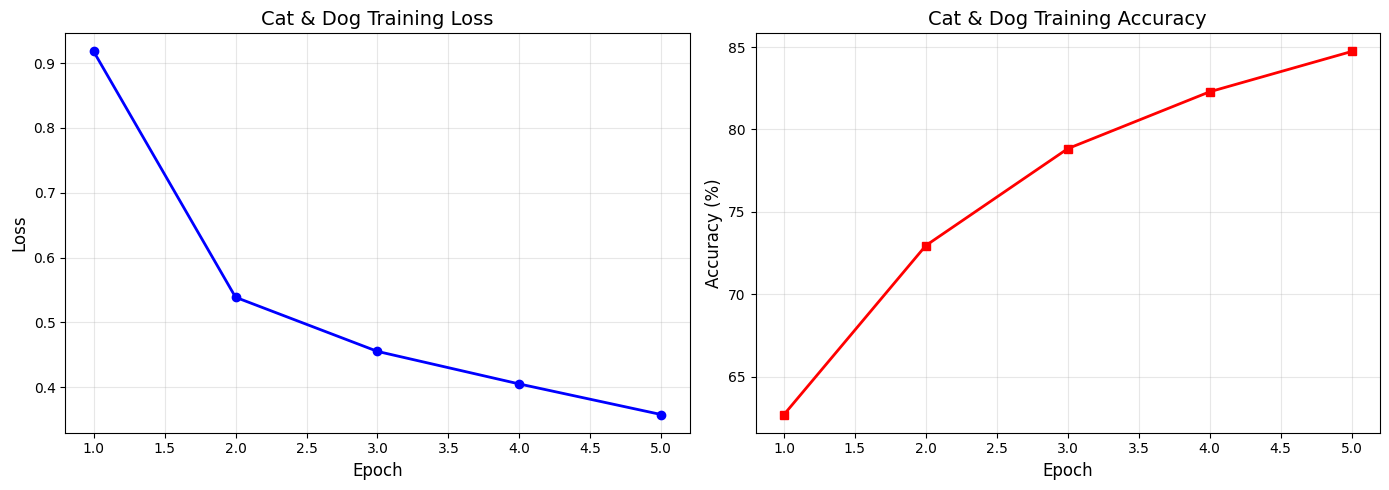

Lỗi đọc ảnh ./data/Dog/11702.jpg: cannot identify image file './data/Dog/11702.jpg'
Cat & Dog - Độ chính xác trên tập test: 87.12 %


In [ ]:
# đánh giá 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


ax1.plot(range(1, len(catdog_loss_history)+1), catdog_loss_history, 'b-', linewidth=2, marker='o')
ax1.set_title('Cat & Dog Training Loss', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, alpha=0.3)
ax2.plot(range(1, len(catdog_acc_history)+1), catdog_acc_history, 'r-', linewidth=2, marker='s')
ax2.set_title('Cat & Dog Training Accuracy', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
catdog_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in catdog_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = catdog_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

catdog_accuracy = 100 * correct / total
print(f'Cat & Dog - Độ chính xác trên tập test: {catdog_accuracy:.2f} %')